<a href="https://colab.research.google.com/github/etomoscow/DL-in-NLP/blob/master/hw3/task4_sentiment_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assignment 2.4: Text classification via CNN (20 points)

In this assignment you should perform sentiment analysis of the IMDB reviews based on CNN architecture. Read carefully [Convolutional Neural Networks for Sentence Classification](https://arxiv.org/pdf/1408.5882.pdf) by Yoon Kim.

In [0]:
import numpy as np
import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchtext import datasets
from torchtext.data import Field, LabelField
from torchtext.data import BucketIterator

### Preparing Data

In [0]:
TEXT = Field(sequential=True,
             lower=True,
             batch_first=True,
             fix_length=200,
             include_lengths=True
             )
LABEL = LabelField(batch_first=True)

In [4]:
train, tst = datasets.IMDB.splits(TEXT, LABEL)
trn, vld = train.split()

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:09<00:00, 8.65MB/s]


In [6]:
%%time
TEXT.build_vocab(trn)

CPU times: user 1.08 s, sys: 17.9 ms, total: 1.1 s
Wall time: 1.1 s


In [0]:
LABEL.build_vocab(trn)

### Creating the Iterator (2 points)

Define an iterator here

In [0]:
train_iter, val_iter, test_iter = BucketIterator.splits(
        (trn, vld, tst),
        batch_sizes=(64, 64, 64),
        sort=False,
        sort_key= lambda x: len(x.text),
        sort_within_batch=False,
        device='cuda',
        repeat=False
)

In [0]:
batch = next(train_iter.__iter__())

### Define CNN-based text classification model (8 points)

In [0]:
class CNN(nn.Module):
    def __init__(self, V, D, kernel_sizes, stride=1, padding=0, dropout=0.5, out_channels=1):
        super(CNN, self).__init__()
        
        self.V = V
        self.D = D
        self.kernel_sizes = kernel_sizes
        self.stride = stride
        self.padding = padding
        self.dropout = dropout
        self.out_channels = out_channels
    
        self.embs = nn.Embedding(V, D, padding_idx=1)
        self.conv1 = nn.Conv2d(1, out_channels,(kernel_sizes[0], D))
        self.conv2 = nn.Conv2d(1, out_channels, (kernel_sizes[1], D))
        self.conv3 = nn.Conv2d(1, out_channels, (kernel_sizes[2], D))
        self.dp = nn.Dropout(dropout)
        self.lin = nn.Linear(len(kernel_sizes)*out_channels, 2)
    
    
    def convolution_block(self, input, conv):
        conved = conv(input)
        act = F.relu(conved.squeeze(3))
        out = F.max_pool1d(act, act.size()[2]).squeeze(2)

        return out
    def forward(self, x):
        
        x = self.embs(x).unsqueeze(1)
        out1 = self.convolution_block(x, self.conv1)
        out2 = self.convolution_block(x, self.conv2)
        out3 = self.convolution_block(x, self.conv3)

        concat = self.dp(torch.cat((out1, out2, out3), 1))
        logit = self.lin(concat)
        return logit

In [0]:
kernel_sizes = [3,4,5]
vocab_size = len(TEXT.vocab)
dropout = 0.3
dim = 256

model = CNN(vocab_size, dim, kernel_sizes, dropout)

In [114]:
model.cuda()

CNN(
  (embs): Embedding(201649, 256, padding_idx=1)
  (conv1): Conv2d(1, 1, kernel_size=(3, 256), stride=(1, 1))
  (conv2): Conv2d(1, 1, kernel_size=(4, 256), stride=(1, 1))
  (conv3): Conv2d(1, 1, kernel_size=(5, 256), stride=(1, 1))
  (dp): Dropout(p=0.5, inplace=False)
  (lin): Linear(in_features=3, out_features=2, bias=True)
)

### The training loop (3 points)

Define the optimization function and the loss functions.

In [0]:
opt = optim.Adam(model.parameters(), lr=0.002)
loss_func = nn.CrossEntropyLoss()

Think carefully about the stopping criteria. 

In [0]:
epochs = 10

In [117]:
%%time
train_loss, valid_loss = [], []
for epoch in range(1, epochs + 1):
    train_acc, val_acc = [], []
    running_loss = 0.0
    running_corrects = 0
    model.train() 
    for batch in train_iter:         
        
        x = batch.text[0]
        y = batch.label
        
        opt.zero_grad()
        preds = model(x)
        loss = loss_func(preds, y)
        loss.backward()
        opt.step()
        running_loss += loss.item()
        
        n_correct = (torch.max(preds, 1)[1].view(y.size()).data == y.data).float().sum().detach().cpu().numpy()
        train_acc.append(100.0 * n_correct/len(batch))


    epoch_loss = running_loss / len(trn)
    train_loss.append(epoch_loss)

    val_loss = 0.0
    model.eval()
    correct = 0
    total = 0 
    for batch in val_iter:
        with torch.no_grad():
            x = batch.text[0]
            y = batch.label
        
            preds = model(x)
            loss = loss_func(preds, y)
            val_loss += loss.item()

            n_correct = (torch.max(preds, 1)[1].view(y.size()).data == y.data).float().sum().detach().cpu().numpy()
            val_acc.append(100.0 * n_correct/len(batch))

    val_loss /= len(vld)
    valid_loss.append(val_loss)
    print('Epoch: {}, Training Loss: {}, Training Accuracy: {}, Validation Loss: {}, Validation Accuracy: {}'.format(epoch, round(epoch_loss, 5), round(np.mean(train_acc), 2), round(val_loss, 5), round(np.mean(val_acc), 2)))

Epoch: 1, Training Loss: 0.0109, Training Accuracy: 52.39, Validation Loss: 0.01037, Validation Accuracy: 62.71
Epoch: 2, Training Loss: 0.01044, Training Accuracy: 55.62, Validation Loss: 0.01015, Validation Accuracy: 65.51
Epoch: 3, Training Loss: 0.01007, Training Accuracy: 60.87, Validation Loss: 0.00963, Validation Accuracy: 69.2
Epoch: 4, Training Loss: 0.00942, Training Accuracy: 65.98, Validation Loss: 0.00921, Validation Accuracy: 70.22
Epoch: 5, Training Loss: 0.00871, Training Accuracy: 70.35, Validation Loss: 0.00903, Validation Accuracy: 70.43
Epoch: 6, Training Loss: 0.00787, Training Accuracy: 74.41, Validation Loss: 0.00882, Validation Accuracy: 70.81
Epoch: 7, Training Loss: 0.00722, Training Accuracy: 77.12, Validation Loss: 0.00887, Validation Accuracy: 70.76
Epoch: 8, Training Loss: 0.00664, Training Accuracy: 78.73, Validation Loss: 0.00916, Validation Accuracy: 69.76
Epoch: 9, Training Loss: 0.00628, Training Accuracy: 80.24, Validation Loss: 0.00938, Validation A

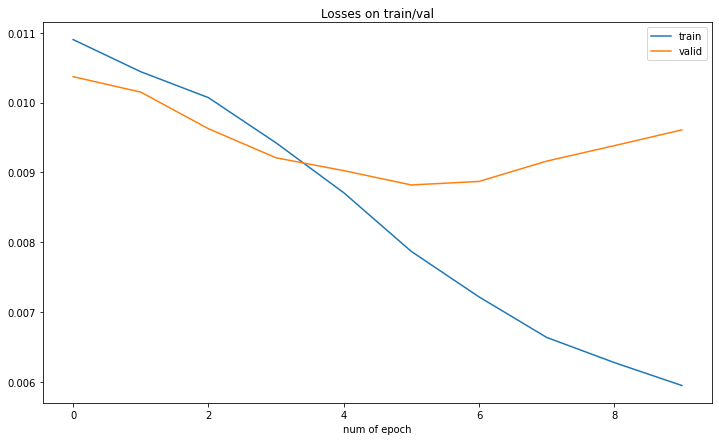

In [118]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,7))
plt.title('Losses on train/val')
plt.plot(train_loss, label='train')
plt.plot(valid_loss, label='valid')
plt.xlabel('num of epoch')
plt.legend(loc='best')

### Calculate performance of the trained model (2 points)

In [119]:
model.eval()
accuracy = []
for batch in test_iter:
    with torch.no_grad():
        x = batch.text[0]
        y = batch.label
        preds = model(x)
        n_correct = (torch.max(preds, 1)[1].view(y.size()).data == y.data).float().sum().detach().cpu().numpy()
        accuracy.append(100.0 * n_correct/len(batch))
print(np.mean(accuracy))

69.33264066496163


Write down the calculated performance

### Accuracy:
### Precision:
### Recall:
### F1:

### Experiments (5 points)

Experiment with the model and achieve better results. Implement and describe your experiments in details, mention what was helpful.

### 1. ?
### 2. ?
### 3. ?